# Postcode Pricing

https://virginmediao2.atlassian.net/browse/CS-2330

Various periods -- including 10th - 30th May

In [3]:
import numpy as np
import pandas as pd
from google.cloud import bigquery

import seaborn as sns 
import matplotlib.pyplot as plt 

In [4]:
%load_ext google.cloud.bigquery
project_id ='prj-vo-aa-p-data-science-exp'

# Parameters

In [3]:
# these are the start / end dates from the campaign roadmap
params = {
    'start_date': '2023-05-10',
    'end_date': '2023-05-30'
}

# Plot setup

In [4]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(16,6),
    titlesize=12,
    titleweight="bold",
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize=12,
    titleweight="bold",
    titlesize=12,
    titlepad=10,
)

plt.rc(
    "legend",
    fontsize=12
)

plot_params = dict(
    color="0.75",
    style="._",
    markeredgecolor="0.25",
    marketfacecolor="0.25",
    legend=True
)

# Data

### Postcodes and allocated treatment groups

In [5]:
%%bigquery selection --project $project_id

SELECT *

FROM `prj-vo-aa-p-data-science-exp.m7914180.cs-2330-postcode-pricing-selection-20230510`


/Users/jonathan.martin/PythonProjects/postcode_pricing/venv/lib/python3.9/site-packages/google/cloud/bigquery/job/query.py:1687: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Users/jonathan.martin/PythonProjects/postcode_pricing/venv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2007: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [6]:
selection.head()

Start_date    End_date  postcode  bundle_id  price  expected_price  \
0  2023-04-17  2023-05-30  AL10 0RP       9310     50            15.0   
1  2023-04-17  2023-05-30   AL3 5UP       9310     50            15.0   
2  2023-04-17  2023-05-30   AL4 9BJ       9310     50            15.0   
3  2023-04-17  2023-05-30   AL7 1SF       9309     44            15.0   
4  2023-04-17  2023-05-30   AL7 3TD       9309     44            15.0   

   delta_price treatment  delta_price_duration  overbuild  bbi_service_flag  \
0           17  control2                    -1          0                 1   
1           17  control1                    -1          1                 1   
2           17  control2                    -1          0                 1   
3           14  control2                    -1          0                 1   
4           14  variant1                    -1          1                 1   

   telco_service_flag  catv_service_flag  dtv_service_flag  \
0                   1                  1                 1   
1                   1                  1                 1   
2                   1                  1                 1   
3                   1                  1                 1   
4                   1                  1                 1   

   bbi_max_ds_speed_res  households data_layer_group  seqnum  
0               1000000        58.0             beta  116007  
1               1000000        59.0             beta   59181  
2               1000000        64.0             beta  205679  
3               1000000        60.0             beta  271487  
4               1000000        58.0             beta   68146

### Sales by postcode by day, along with the treatment group the postcode was assigned to

It would be useful to identify different contract lengths, but we don't have this data until 26 October 2023.

In [7]:
%%bigquery purchases --project $project_id --params $params

WITH
treatment_groups AS (

    SELECT DISTINCT 
        postcode,
        treatment,

    FROM `prj-vo-aa-p-data-science-exp.m7914180.cs-2330-postcode-pricing-selection-20230510`

),

purchases AS (

    -- calling this 'purchases' because it is unclear if it is orders or sales
    SELECT 
        event_date,
        session_key,
        premise_event_parameters.premise_uid,
        user_pseudo_id,
        icoms_account_uid,
        is_order,
        i.item_name, 
        i.item_name_unbundled,
        i.item_brand,
        i.item_category,
        i.item_category2,
        i.item_category3,
        i.price,
        i.item_revenue,
        i.tld_price,
        i.contract_length -- valuea missing until 26 October 2023

    FROM 
        `prj-vo-aa-p-dp-analytics-uat.digital_product_ga4.ga4__events`,
        UNNEST(items) i

    WHERE event_date BETWEEN @start_date AND @end_date
    AND event_name = 'purchase'
    AND item_brand = 'cable'
    
),

postcodes AS (

    SELECT DISTINCT
        icoms_id.icoms_premises_uid,
        premises_location.postcode,
    FROM
        `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

)

SELECT
  prch.*,
  pc.postcode,
  grp.*
    
FROM purchases prch

  LEFT JOIN postcodes pc
  ON prch.premise_uid = pc.icoms_premises_uid

  LEFT JOIN treatment_groups grp
  ON pc.postcode = grp.postcode

WHERE icoms_account_uid IS NULL -- new customers?



/Users/jonathan.martin/PythonProjects/postcode_pricing/venv/lib/python3.9/site-packages/google/cloud/bigquery/job/query.py:1687: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Users/jonathan.martin/PythonProjects/postcode_pricing/venv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2007: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [8]:
purchases = purchases.astype({
    'event_date': 'datetime64[ns]'
})

purchases.shape

(28808, 19)

In [9]:
purchases.head()

event_date               session_key  premise_uid         user_pseudo_id  \
0 2023-05-26  X83BhdNwhly82yZ5qQo+MA==    112391291  1537387319.1674827084   
1 2023-05-26  tchMCFLUdKCLrYB0RGnx0Q==         <NA>   939855994.1671115592   
2 2023-05-26  jEGxYomFrPC8mcJX66yf/Q==         <NA>  1113279709.1683102751   
3 2023-05-15  qqCV2OZj71t7SaWX4mDmUA==    319093384   206185418.1683628608   
4 2023-05-24  3B8D+6jMY9N66WqUzKvnIQ==    206576795  1321788510.1684941898   

   icoms_account_uid  is_order               item_name  \
0               <NA>         1     m50 fibre broadband   
1               <NA>         0              big bundle   
2               <NA>         0      bigger volt bundle   
3               <NA>         1   m50 broadband + phone   
4               <NA>         1  m125 broadband + phone   

        item_name_unbundled item_brand item_category item_category2  \
0     [m50 fibre broadband]      cable         cable          solus   
1              [big bundle]      cable         cable         triple   
2      [bigger volt bundle]      cable         cable         triple   
3   [m50 broadband + phone]      cable         cable           dual   
4  [m125 broadband + phone]      cable         cable           dual   

  item_category3  price  item_revenue  tld_price  contract_length  postcode  \
0      (not set)  38.00         38.00        NaN             <NA>  EH48 2EF   
1      (not set)  33.74         33.74        NaN             <NA>      None   
2      (not set)  59.99         59.99        NaN             <NA>      None   
3      (not set)  28.00         28.00        NaN             <NA>  ST14 8WF   
4      (not set)  34.00         34.00        NaN             <NA>    M6 8QA   

  postcode_1 treatment  
0       None      None  
1       None      None  
2       None      None  
3       None      None  
4     M6 8QA  variant2

# Bundle ID to item name lookup

Is this recorded anywhere, or do I have to guess based on prices?

In [10]:
purchases.groupby(['treatment', 'item_name', 'contract_length']).agg(mean_price = ('price', 'mean'))


Empty DataFrame
Columns: [mean_price]
Index: []

In [11]:
purchases.item_name.value_counts().index.to_list()

['m125 fibre broadband',
 'm250 fibre broadband',
 'big bundle',
 'gig1 fibre broadband',
 'bigger bundle',
 'volt m250 fibre broadband',
 'bigger bundle + sports',
 'ultimate volt bundle',
 'fibre broadband volt',
 'm350 fibre broadband',
 'ultimate volt',
 'm500 fibre broadband',
 'big volt bundle',
 'bigger volt bundle',
 'm50 fibre broadband',
 'm50 broadband + phone',
 'm125 broadband + phone',
 'fibre broadband + home phone volt',
 'big bundle + drama & docs',
 'volt m350 fibre broadband',
 'bigger bundle + movies',
 'volt m250 fibre broadband + phone',
 'bigger volt bundle + sports',
 'volt gig1 fibre broadband',
 'biggest tv bundle',
 'volt m500 fibre broadband',
 'm250 broadband + phone',
 'm1000 broadband + phone',
 'm50 fibre broadband & weekend chatter',
 'volt m1000 fibre broadband + phone',
 'm350 broadband + tv',
 'm50 fibre broadband & anytime chatter',
 'm500 broadband + phone',
 'big volt bundle + drama & docs',
 'm125 fibre broadband & weekend chatter',
 'volt m350 f

In [12]:
# guesses

bundle_id_lookup = {

    9310: '...',
    9309: '...',
    9311: '...',
    9312: '...',
    9313: '...',
    4301: '...',
    4300: '...',
    4304: '...',
    4302: '...',
    4305: '...',
    4019: '...',
    4020: '...',
    4021: '...',
    4015: '...',
    4016: '...',
    4017: '...'

}

In [13]:
selection[['bundle_id', 'treatment', 'expected_price']].drop_duplicates().pivot(index='bundle_id', columns='treatment', values='expected_price').sort_values('control1')

treatment  control1  control2  variant1  variant2
bundle_id                                        
9309          15.00     15.00     15.00     17.00
9310          15.00     15.00     15.00     17.00
9311          21.00     21.00     21.00     23.00
4302          26.50     26.50     26.50     28.50
9312          27.00     27.00     27.00     29.00
9313          30.00     30.00     30.00     32.00
4015          31.99     31.99     31.99     33.99
4301          32.50     32.50     32.50     34.50
4016          37.99     37.99     37.99     39.99
4300          38.50     38.50     38.50     40.50
4019          39.50     39.50     39.50     41.50
4017          43.99     43.99     43.99     45.99
4304          44.50     44.50     44.50     46.50
4305          45.00     45.00     45.00     47.00
4020          45.50     45.50     45.50     47.50
4021          51.50     51.50     51.50     53.50

# Aggregates

Do various convenient aggregates up front here

In [14]:
daily_sales = (purchases[~purchases.treatment.isna()]
               .groupby(['treatment', 'item_name', 'event_date'])
               .size()
               .reset_index(name='num_sales')
               .pivot(
                   index='event_date',
                   columns=['treatment', 'item_name'],
                   values='num_sales'
                )
                .sort_index()
                )

daily_sales.head()

treatment    control1                                            \
item_name  big bundle big bundle + drama & docs big volt bundle   
event_date                                                        
2023-05-10       14.0                       1.0             1.0   
2023-05-11       15.0                       1.0             1.0   
2023-05-12       15.0                       NaN             NaN   
2023-05-13        8.0                       NaN             1.0   
2023-05-14        9.0                       NaN             NaN   

treatment                                                \
item_name  big volt bundle + drama & docs bigger bundle   
event_date                                                
2023-05-10                            NaN           4.0   
2023-05-11                            NaN           7.0   
2023-05-12                            NaN           7.0   
2023-05-13                            NaN           5.0   
2023-05-14                            NaN           4.0   

treatment                                                                    \
item_name  bigger bundle + movies bigger bundle + sports bigger volt bundle   
event_date                                                                    
2023-05-10                    NaN                    2.0                1.0   
2023-05-11                    1.0                    5.0                NaN   
2023-05-12                    NaN                    3.0                2.0   
2023-05-13                    NaN                    4.0                NaN   
2023-05-14                    NaN                    2.0                NaN   

treatment                                                 ...  \
item_name  bigger volt bundle + sports biggest tv bundle  ...   
event_date                                                ...   
2023-05-10                         NaN               NaN  ...   
2023-05-11                         NaN               1.0  ...   
2023-05-12                         1.0               NaN  ...   
2023-05-13                         1.0               NaN  ...   
2023-05-14                         NaN               NaN  ...   

treatment              variant2                       \
item_name  m500 fibre broadband ultimate volt bundle   
event_date                                             
2023-05-10                  2.0                  4.0   
2023-05-11                  2.0                  1.0   
2023-05-12                  4.0                  7.0   
2023-05-13                  2.0                  5.0   
2023-05-14                  3.0                  4.0   

treatment                                                                \
item_name  volt gig1 fibre broadband volt m1000 fibre broadband + phone   
event_date                                                                
2023-05-10                       1.0                                NaN   
2023-05-11                       NaN                                NaN   
2023-05-12                       NaN                                NaN   
2023-05-13                       NaN                                NaN   
2023-05-14                       NaN                                NaN   

treatment                                                               \
item_name  volt m250 fibre broadband volt m250 fibre broadband + phone   
event_date                                                               
2023-05-10                       8.0                               NaN   
2023-05-11                       5.0                               1.0   
2023-05-12                       8.0                               NaN   
2023-05-13                       4.0                               NaN   
2023-05-14                       3.0                               NaN   

treatment                                                               \
item_name  volt m350 fibre broadband volt m350 fibre broadband + phone   
event_date                                   

In [15]:
overall_price_variation = (purchases[~purchases.treatment.isna()]
                           .groupby(['treatment', 'item_name'])
                           .agg(
                                min_price = ('price', 'min'),
                                max_price = ('price', 'max'),
                                mean_price = ('price', 'mean'),
                            )
                            .reset_index()
                            .pivot(
                                index='item_name',
                                columns='treatment', 
                                values=['min_price', 'max_price', 'mean_price']
                            )
                            .sort_index()
                            )
overall_price_variation.head()

min_price                            max_price  \
treatment                       control1 control2 variant1 variant2  control1   
item_name                                                                       
big bundle                          0.00    31.99    31.99    31.99     74.99   
big bundle + drama & docs          37.99    37.99    37.99    37.99     41.49   
big volt bundle                    31.99    31.99    31.99    31.99     43.99   
big volt bundle + drama & docs     49.99      NaN      NaN    49.99     49.99   
bigger bundle                      39.50    39.50    39.50    39.50     67.00   

                                                            mean_price  \
treatment                      control2 variant1   variant2   control1   
item_name                                                                
big bundle                        59.99   126.24  78.990000  32.978280   
big bundle + drama & docs         37.99    58.99  53.990000  38.690000   
big volt bundle                   56.99    51.99  60.990000  36.337826   
big volt bundle + drama & docs      NaN      NaN  65.989999  49.990000   
bigger bundle                     64.50    58.00  73.500000  41.406593   

                                                                 
treatment                        control2   variant1   variant2  
item_name                                                        
big bundle                      32.843852  33.217842  34.469016  
big bundle + drama & docs       37.990000  41.847143  38.878889  
big volt bundle                 39.990000  37.813529  39.333750  
big volt bundle + drama & docs        NaN        NaN  59.323333  
bigger bundle                   41.182065  40.909091  42.728916

In [16]:
daily_price_variation = (purchases[~purchases.treatment.isna()]
                           .groupby(['treatment', 'item_name', 'event_date'])
                           .agg(
                                min_price = ('price', 'min'),
                                max_price = ('price', 'max'),
                                mean_price = ('price', 'mean'),
                            )
                            .reset_index()
                            .pivot(
                                index='event_date',
                                columns=['item_name', 'treatment'], 
                                values=['min_price', 'max_price', 'mean_price']
                            )
                            .sort_index()
                            )

daily_price_variation.head()


min_price                                            \
item_name  big bundle big bundle + drama & docs big volt bundle   
treatment    control1                  control1        control1   
event_date                                                        
2023-05-10      31.99                     37.99           43.99   
2023-05-11      31.99                     41.49           31.99   
2023-05-12      31.99                       NaN             NaN   
2023-05-13      31.99                       NaN           36.99   
2023-05-14      31.99                       NaN             NaN   

                                                         \
item_name  big volt bundle + drama & docs bigger bundle   
treatment                        control1      control1   
event_date                                                
2023-05-10                            NaN          39.5   
2023-05-11                            NaN          39.5   
2023-05-12                            NaN          39.5   
2023-05-13                            NaN          39.5   
2023-05-14                            NaN          39.5   

                                                                             \
item_name  bigger bundle + movies bigger bundle + sports bigger volt bundle   
treatment                control1               control1           control1   
event_date                                                                    
2023-05-10                    NaN                   65.0              54.99   
2023-05-11                   62.0                   65.0                NaN   
2023-05-12                    NaN                   65.0              49.99   
2023-05-13                    NaN                   65.0                NaN   
2023-05-14                    NaN                   75.0                NaN   

                                                          ...  \
item_name  bigger volt bundle + sports biggest tv bundle  ...   
treatment                     control1          control1  ...   
event_date                                                ...   
2023-05-10                         NaN               NaN  ...   
2023-05-11                         NaN              87.0  ...   
2023-05-12                        90.0               NaN  ...   
2023-05-13                        77.0               NaN  ...   
2023-05-14                         NaN               NaN  ...   

                     mean_price                       \
item_name  m500 fibre broadband ultimate volt bundle   
treatment              variant2             variant2   
event_date                                             
2023-05-10                37.75                 85.0   
2023-05-11                40.50                 85.0   
2023-05-12                39.00                 85.0   
2023-05-13                38.50                 85.0   
2023-05-14                38.50                 85.0   

                                                                         \
item_name  volt gig1 fibre broadband volt m1000 fibre broadband + phone   
treatment                   variant2                           variant2   
event_date                                                                
2023-05-10                      45.0                                NaN   
2023-05-11                       NaN                                NaN   
2023-05-12                       NaN                                NaN   
2023-05-13                       NaN                                NaN   
2023-05-14                       NaN                                NaN   

                                                                        \
item_name  volt m250 fibre broadband volt m250 fibre broadband + phone   
treatment                   variant2                          variant2   
event_date                                                               
2023-05-10                    32.740                               NaN   
2023-05-11                 

# Sense checking

In [17]:
purchases.groupby('treatment').agg(num_postcodes = ('postcode', 'nunique'))

num_postcodes
treatment               
control1            2564
control2            4142
variant1            2415
variant2            3958

In [18]:
purchases.query("item_name == 'm125 fibre broadband'").treatment.value_counts(normalize=True)

control2    0.313208
variant2    0.298635
control1    0.203331
variant1    0.184825
Name: treatment, dtype: float64

# Questions

In [19]:
# Are prices being recorded correctly now? I heard there was an issue, but no details or updates

In [20]:
# we don't have contract length before mid-October?

In [21]:
# how was traffic actually split?

In [ ]:
# how do we identify affiliates in GA4?
...

### Inspect the overall pattern of sales -- anything odd?

In [22]:
selected_item_name = 'm125 fibre broadband'

idx = pd.IndexSlice
sns.lineplot(data=daily_sales.loc(1)[:,idx[selected_item_name]])

<AxesSubplot: xlabel='event_date'>

### were prices consistently applied to the treatment and control products?



In [23]:
# average prices across treatments are quite similar?
selected_item_name = 'm125 fibre broadband'

overall_price_variation.query('item_name == @selected_item_name')

min_price                            max_price           \
treatment             control1 control2 variant1 variant2  control1 control2   
item_name                                                                      
m125 fibre broadband       0.0     15.0      0.0      0.0      44.0     44.0   

                                       mean_price                       \
treatment            variant1 variant2   control1   control2  variant1   
item_name                                                                
m125 fibre broadband     44.0     44.0   26.49934  26.526928  26.34164   

                                
treatment             variant2  
item_name                       
m125 fibre broadband  26.87096

/var/folders/pq/1pygt1_j2fn4w2qq_zh70bdh0000gp/T/ipykernel_17488/1893023315.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.lineplot(data=daily_price_variation.loc(1)[idx['mean_price'], idx[selected_item_name]])


Text(0.5, 1.0, 'Daily mean price of m125 fibre broadband between 2023-05-10 and 2023-05-30')

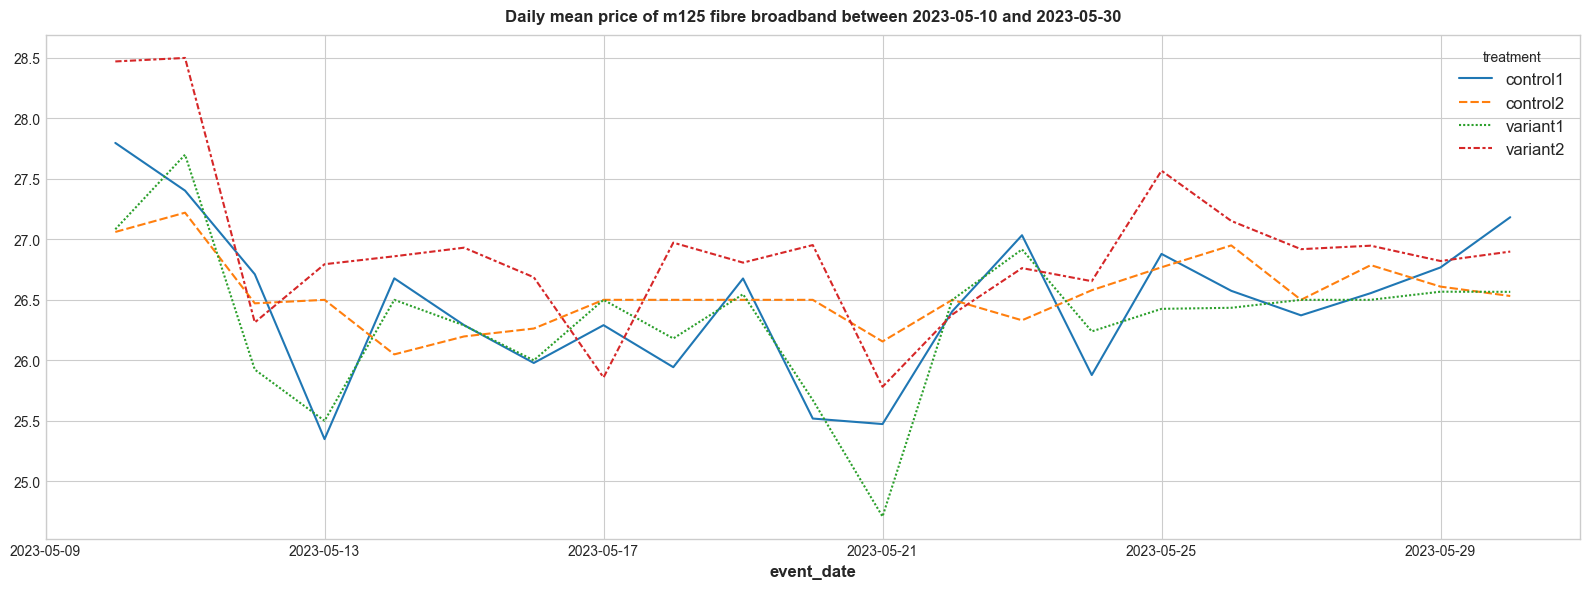

In [26]:
# sns.lineplot(data=daily_prices_by_treatment.query('item_name == @selected_item_name'), x='event_date', y='price', hue='treatment', errorbar=('ci', True))
# plt.title(f"Daily prices for {selected_item_name} between {params['start_date']} and {params['end_date']}")

selected_item_name = 'm125 fibre broadband'

idx = pd.IndexSlice
sns.lineplot(data=daily_price_variation.loc(1)[idx['mean_price'], idx[selected_item_name]])

plt.title(f"Daily mean price of {selected_item_name} between {params['start_date']} and {params['end_date']}")


In [27]:
selected_items = ["m125 fibre broadband", "m250 fibre broadband"]
selected_treatments = ['variant2']  

plot_data = (purchases
             .query('treatment in @selected_treatments')
             .query('item_name in @selected_items')
             .groupby(['event_date', 'item_name', 'treatment']).size().reset_index(name='num_sales')
             .pivot(index='event_date', columns=['item_name', 'treatment'], values='num_sales')
             )
             
plot_data.columns = plot_data.columns.to_flat_index()

sns.lineplot(data=plot_data)

plt.title("Daily sales of selected products")

plt.axvline(pd.Timestamp(params['start_date']), linestyle='dashed', color='red')
plt.axvline(pd.Timestamp(params['end_date']), linestyle='dashed', color='red')

In [28]:
# were there cheaper options available for certain products? -- i.e. was M250 ever cheaper than M125?
selected_item_names = ["m125 fibre broadband", "m250 fibre broadband"]

(purchases
.query('item_name in @selected_item_names')
.groupby(['event_date', 'item_name', 'treatment'])
.agg(
    min_price = ('price', 'min'),
    max_price = ('price', 'max')
)
.reset_index()
.pivot(
    index=['event_date','treatment'],
    columns='item_name',
    values=['min_price', 'max_price']
)
)

min_price                       \
item_name            m125 fibre broadband m250 fibre broadband   
event_date treatment                                             
2023-05-10 control1                  26.5                 15.0   
           control2                  15.0                 15.0   
           variant1                   0.0                 15.0   
           variant2                  26.5                 15.0   
2023-05-11 control1                  15.0                 15.0   
...                                   ...                  ...   
2023-05-29 variant2                  24.0                 30.5   
2023-05-30 control1                  26.5                 30.5   
           control2                  24.0                 30.5   
           variant1                  26.5                 30.5   
           variant2                  24.0                 28.0   

                                max_price                       
item_name            m125 fibre broadband m250 fibre broadband  
event_date treatment                                            
2023-05-10 control1                 28.50                 33.0  
           control2                 28.50                 33.0  
           variant1                 28.50                 33.0  
           variant2                 28.99                 34.5  
2023-05-11 control1                 28.50                 32.5  
...                                   ...                  ...  
2023-05-29 variant2                 28.50                 35.0  
2023-05-30 control1                 44.00                 33.0  
           control2                 30.00                 50.0  
           variant1                 30.00                 50.0  
           variant2                 28.99                 35.0  

[84 rows x 4 columns]